In [1]:
# Dependencies
%pylab inline
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import matplotlib.ticker as mtick
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Data Description
+ H-1B Visa Petitions for 2011 - 2016

+ Source [Kaggle H-1B Visa Petitions 2011-2016](https://www.kaggle.com/nsharan/h-1b-visa)

### Context 
---
The H-1B is an employment-based, non-immigrant visa category for temporary foreign workers in the United States. For a foreign national to apply for H1-B visa, an US employer must offer a job and petition for H-1B visa with the US immigration department. This is the most common visa status applied for and held by international students once they complete college/ higher education (Masters, PhD) and work in a full-time position.

The Office of Foreign Labor Certification (OFLC) generates program data that is useful information about the immigration programs including the H1-B visa.

### Content
#### Number of Instances : 
#### Features:
1. CASE_STATUS: Status associated with the last significant event or decision. Valid values include “Certified,” “Certified-Withdrawn,” Denied,” and “Withdrawn”.  
** NOTE: Certified does not mean the employee was granted an H-1B Visa rather. Certified is a status that allows the application to apply for an H-1B Visa **
2. EMPLOYER_NAME: Name of employer submitting labor condition application
3. SOC_NAME: Standard Occupation Code according to SOC Classification system. 
4. JOB TITLE: Title of the employee position
5. FULL_TIME_POSITION: Y = Full Time Position, N = Part Time Position
6. PREVAILING_WAGE: Prevailing Wage for the job being requested for temporary labor condition. The wage is listed at annual scale in USD. The prevailing wage for a job position is defined as the average wage paid to similarly employed workers in the requested occupation in the area of intended employment. The prevailing wage is based on the employer’s minimum requirements for the position. 
7. YEAR: Year in which the H-1B visa petition was filed
8. WORKSITE: City and State Information of the foreign worker's intended area of employment
9. Lon : Longitude of worksite
10. Lon : latitude of worksite

# Read Data
___

In [2]:
filePath = "./Data/h1b_kaggle.csv"
df = pd.read_csv(filePath, header=0)

### General Data Cleaning
___

In [3]:
df[:3]

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158


+ ** Remove the features that we do not need for any analysis we intend to perform **

In [4]:
# remove the first index column
del df["Unnamed: 0"]

In [5]:
len(df)

3002458

In [6]:
# Remove "Lon" and "Lat"
del df["lon"]
del df["lat"]

In [7]:
df[:3]

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN"
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS"
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY"


In [8]:
worksite = df["WORKSITE"]
worksite[:3]

0        ANN ARBOR, MICHIGAN
1               PLANO, TEXAS
2    JERSEY CITY, NEW JERSEY
Name: WORKSITE, dtype: object

In [9]:
df[["CITY", "STATE"]] = df["WORKSITE"].str.split(', ', expand=True)
df[:3]

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",PLANO,TEXAS
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",JERSEY CITY,NEW JERSEY


In [10]:
## Now delete the worksite feature
del df["WORKSITE"]

In [11]:
df[:3]

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,PLANO,TEXAS
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,JERSEY CITY,NEW JERSEY


## Feature-specific Data Cleaning

#### CASE_STATUS
___

In [12]:
case_status_series = df["CASE_STATUS"]

In [13]:
## Analyze the values in Case status
print(case_status_series.value_counts())

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64


In [14]:
## We are only intrested in these outcomes 
# certified | certified-withdraw | denied | Withdrawn 
# The others are outliers. Lets remove them 
df.drop(df[df.CASE_STATUS == "REJECTED"].index, axis=0, inplace=True)
df.drop(df[df.CASE_STATUS == "PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED"].index, axis=0, inplace=True)
df.drop(df[df.CASE_STATUS == "INVALIDATED"].index, axis=0, inplace=True)

In [15]:
## Analyze the values in Case status
print(df["CASE_STATUS"].value_counts())

CERTIFIED              2615623
CERTIFIED-WITHDRAWN     202659
DENIED                   94346
WITHDRAWN                89799
Name: CASE_STATUS, dtype: int64


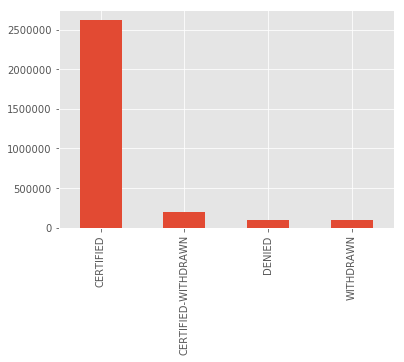

In [16]:
# Check out the distribution of likely outcomes
df["CASE_STATUS"].value_counts().plot.bar()

#### EMPLOYER_NAME
___

In [17]:
# Are there any missing employer names 
print("There %d instances missing employer names" % len(df[pd.isnull(df.EMPLOYER_NAME)]))

There 59 instances missing employer names


+ Since these are not numerical data we cannot imput using a measure of central tendency
+ Since the data seems to be missing completely at random, we should remove it. Cannot figure out what employer name should be from the available data

In [18]:
# Remove Instances without Employer name valued
df = df[pd.notnull(df["EMPLOYER_NAME"])]

#### SOC_NAME
___

+ The SOC_NAME captures the same information as Job title. In the essence of dimension reduction and to only use features that are neccessary. i will remove this feature 

In [19]:
del df["SOC_NAME"]

In [20]:
df[:3]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF OPERATING OFFICER,Y,242674.0,2016.0,PLANO,TEXAS
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF PROCESS OFFICER,Y,193066.0,2016.0,JERSEY CITY,NEW JERSEY


#### JOB TITLE
___

In [21]:
# Do we have any missing values
print("There %d missing instances of job title" % len(df[pd.isnull(df["JOB_TITLE"])]))

There 21 missing instances of job title


In [22]:
# Remove these missing instances
df = df[pd.notnull(df["JOB_TITLE"])]

In [23]:
# How many distinct Job titles are there 
job_stat = df["JOB_TITLE"].value_counts()
print("There %d distinct jobs in the DataSet" %job_stat[0])

There 249034 distinct jobs in the DataSet


#### FULL_TIME_POSITION
___

In [24]:
# Do we have missing values
print("There %d missing instance of full time" % len(df[pd.isnull(df["FULL_TIME_POSITION"])]))

There 1 missing instance of full time


In [25]:
df[pd.isnull(df["FULL_TIME_POSITION"])]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
131977,DENIED,FOUR SEASONS HEATING AND AIR CONDITIONING,COMPUTER SYSTEMS ANALAYST,NaN,NaN,2016.0,CHICAGO,ILLINOIS


In [26]:
# Remove this instance
df = df[pd.notnull(df["FULL_TIME_POSITION"])]

#### PREVAILING WAGE
___

In [27]:
# Do we have any missing values
print("There %d instances missing prevailing values" % len(df[pd.isnull(df["PREVAILING_WAGE"])]))

There 66 instances missing prevailing values


In [28]:
# Applications have to have a wage provided. 
# Remove instances with wages missing
df = df[pd.notnull(df["PREVAILING_WAGE"])]
df[:2]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF OPERATING OFFICER,Y,242674.0,2016.0,PLANO,TEXAS


In [29]:
# We can see that the wage values are in floats. For easier calculations convert these to ints 
df["PREVAILING_WAGE"] = df["PREVAILING_WAGE"].astype(int)
df[:2]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,POSTDOCTORAL RESEARCH FELLOW,N,36067,2016.0,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF OPERATING OFFICER,Y,242674,2016.0,PLANO,TEXAS


#### YEAR
___

In [30]:
# Do we have any missing Data
print("There %d instances missing Year values" % len(df[pd.isnull(df["YEAR"])]))

There 0 instances missing Year values


In [31]:
## That is great, Now, need to convert the year as given to ints 
df["YEAR"] = df["YEAR"].astype(int)
df[:2]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,POSTDOCTORAL RESEARCH FELLOW,N,36067,2016,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF OPERATING OFFICER,Y,242674,2016,PLANO,TEXAS


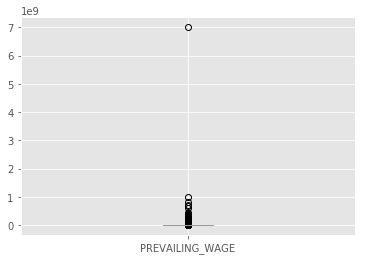

In [32]:
df["PREVAILING_WAGE"].plot.box()

There some outliers here that will complicate my analysis later

In [33]:
## First look at the extreme values at the top 
df["PREVAILING_WAGE"].sort_values(ascending=False)[:10]

2163248    6997606720
2797982    1007814080
1673867     820132347
1819718     709999949
2775906     657900000
1547574     616931693
1668384     413472579
1805875     410315360
2796071     406637920
1698325     389376000
Name: PREVAILING_WAGE, dtype: int64

In [34]:
df["PREVAILING_WAGE"].median()

65021.0

In [35]:
without_outliers = df[~(np.abs(df["PREVAILING_WAGE"] - df["PREVAILING_WAGE"].mean()) > (2 * df["PREVAILING_WAGE"].std()))]

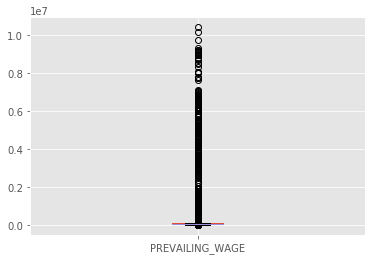

In [36]:
without_outliers["PREVAILING_WAGE"].plot.box()

In [37]:
df = without_outliers

In [38]:
len(df)

3000591

In [39]:
res = 3002458 - 3000591
(res/3002458) * 100

0.06218238523236628

+ ** Although we still have outliers in the Data, we have reduced the amount of noise in the Data significantly by eliminatting the rows where the prevailing wage is greater than 2 standard deviations from mean**
___
+ ** Let us check the distribution of our target feature for classification later**

# Data Exploration
---

#### CASE_STATUS
___

#### One average do most appplications get certified, denied or withdrawn ?

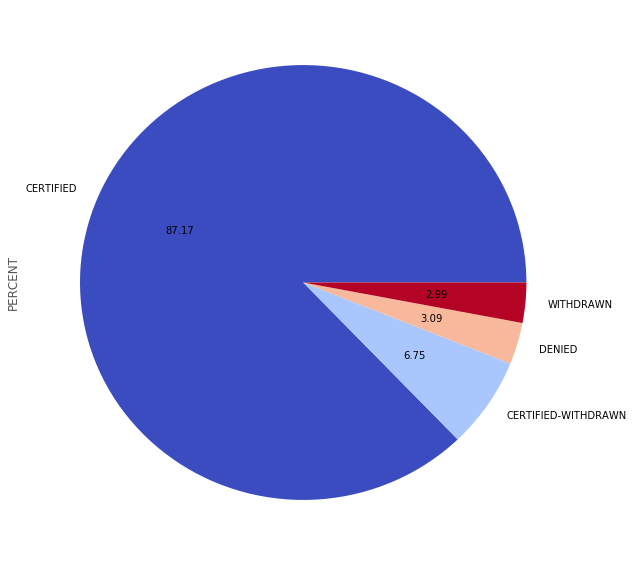

In [40]:
target_dist = pd.DataFrame({"COUNT" : without_outliers.groupby("CASE_STATUS").size()})
total = target_dist.COUNT.sum()
target_dist["PERCENT"] = target_dist.COUNT.apply(lambda x : x /total)
ax_dis = target_dist["PERCENT"].plot.pie(colormap="coolwarm", autopct='%.2f', figsize=(10,10))
ax_dis

**Observation**
+ It seems that most application are accepted than denied or withdrawn

### Of the application that were certified, Which cities had the highest amount of certified applications ?

In [41]:
certified_applications = df["CASE_STATUS"] == "CERTIFIED"
certified_df = df[certified_applications]
city_wages = certified_df.groupby("CITY").agg({"PREVAILING_WAGE": ["count", "mean", "min", "max"]})

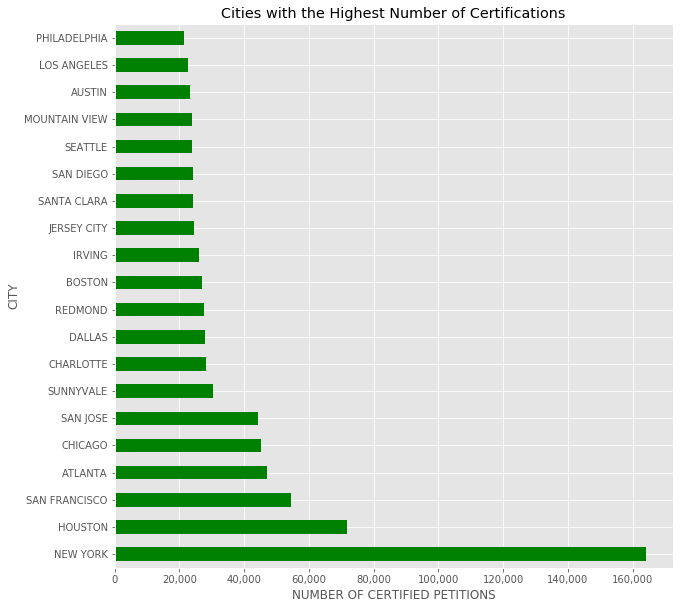

In [42]:
city_wage_stat = city_wages.sort_values([("PREVAILING_WAGE", "count")], ascending=False)[:20]
cit_ax = city_wage_stat[("PREVAILING_WAGE", 'count')].plot.barh(figsize=(10,10), 
                                                                colormap='ocean')

# Set Labels 
cit_ax.set(ylabel='CITY',
           xlabel="NUMBER OF CERTIFIED PETITIONS", 
           title="Cities with the Highest Number of Certifications")
# Format the X axis in a more readable format.
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
cit_ax.xaxis.set_major_formatter(tick) 
# Show the Bar Graph
plt.show()

+ **The top 20 cities with certified applications**

#### PREVAILING_WAGE
___

#### From all the applicants, What are the top 20 highest paying jobs on average
___

In [43]:
f = {"PREVAILING_WAGE" : ["count", "mean"]}
job_wages = df.groupby("JOB_TITLE").agg(f)
jobs_gt_than_thou = job_wages[("PREVAILING_WAGE", "count")] > 1000

+ **Selected the count of 1000 to be the threshold for the support of the mean derived from the wages**
+ **When i assert that a certain profession has X salary on average. I have the support of atleast 1000 applicants for that job**

In [44]:
# Get all the jobs whose count > 1000 and look at the mean wages 
## Sort the wages to get the top 20 highest average wages by profession.
top_job_wages = job_wages[jobs_gt_than_thou].sort_values([("PREVAILING_WAGE", "mean")], ascending=False)[:20]

+ ** Highest average earning professions in H1-B Petitions 2011 - 2016 **

In [45]:
top_job_wages_list = list(top_job_wages.index)
[profession for profession in top_job_wages_list]

['CHIEF EXECUTIVE OFFICER',
 'NEPHROLOGIST',
 'PSYCHIATRIST',
 'HOSPITALIST',
 'HOSPITALIST PHYSICIAN',
 'PHYSICIAN',
 'PEDIATRICIAN',
 'ENGINEERING MANAGER',
 'DIRECTOR',
 'VICE PRESIDENT',
 'PRINCIPAL CONSULTANT - US',
 'ATTORNEY',
 'ASSOCIATE ATTORNEY',
 'PRINCIPAL SOFTWARE ENGINEER',
 'SENIOR PRODUCT MANAGER',
 'STAFF SOFTWARE ENGINEER',
 'SENIOR MANAGER',
 'SOFTWARE ENGINEER 3',
 'DENTIST',
 'LEAD SOFTWARE ENGINEER']

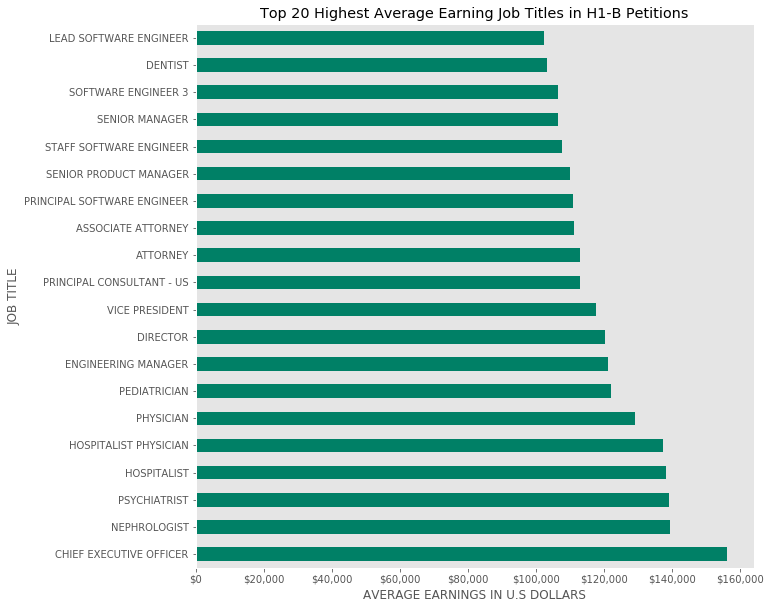

In [46]:

plt.figure()
ax = top_job_wages[("PREVAILING_WAGE", "mean")].plot.barh(figsize=(10,10), 
                                                     grid=False, 
                                                     colormap='summer',
                                                     title="Top 20 Highest Average Earning Job Titles in H1-B Petitions")
ax.set(xlabel='AVERAGE EARNINGS IN U.S DOLLARS', ylabel='JOB TITLE')

# Format the X axis to reflect dollars and present in a more readable format.
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick) 
# plt.xticks(rotation=90)

plt.show()

**Observations**
+ ** Some of the highest paying industries for foreign employees are **
>> + Consulting
>> + Engineering
>> + HealthCare 

#### What job categories  have the most applications ?
___

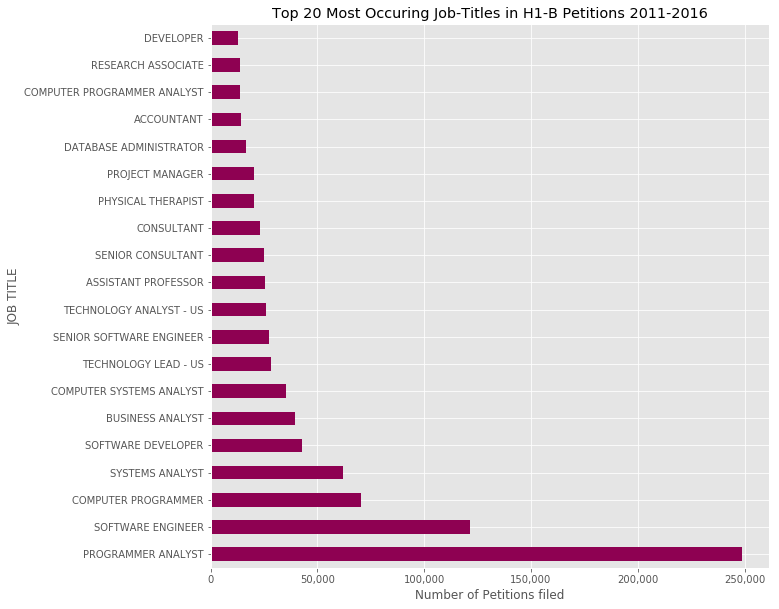

In [47]:
job_cat = job_wages[jobs_gt_than_thou].sort_values([("PREVAILING_WAGE", "count")], ascending=False)[:20]
job_ax = job_cat[("PREVAILING_WAGE", "count")].plot.barh(figsize=(10,10), 
                                                colormap="PiYG",  
                                                title="Top 20 Most Occuring Job-Titles in H1-B Petitions 2011-2016")

job_ax.set(ylabel="JOB TITLE", xlabel="Number of Petitions filed")
# Format the X axis to reflect dollars and present in a more readable format.
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
job_ax.xaxis.set_major_formatter(tick) 

plt.show()

**Observations**
1. The top 10 positions are all technical roles. 
2. 12 / 20 of the most occuring jobs in the applications are technical
3. Accountant, Phyiscal therapy and Consulant are the only Job titles in the top 20 that are not technical
4. Programmer Analyst was the most common job among the applications  
---
** After some research i found an intresting connection between the highest applying employer sponsors and the highest applied for job title, All developers contracted to the the top sponsors ( indian firms ) designate all their developers as "PROGRAMMER ANALYST" - A similar job description as a Software engineer at an American Firm and that is why SOFTWARE ENGINEER is subsquently after PROGRAMMER ANALYST in the rankings **
___



#### EMPLOYER_NAME
___

#### Which employers have the most applications for sponsorship

In [48]:
employer_group_df = df.groupby("EMPLOYER_NAME").agg({"PREVAILING_WAGE": ["count"]}).sort_values([("PREVAILING_WAGE", "count")], ascending=False)[:20]

+ ** The top 20 sponsors of H1-B VIsa Petition 2011 - 2016**

In [49]:
top_20 = list(employer_group_df.index)
[employer for employer in top_20]

['INFOSYS LIMITED',
 'TATA CONSULTANCY SERVICES LIMITED',
 'WIPRO LIMITED',
 'DELOITTE CONSULTING LLP',
 'IBM INDIA PRIVATE LIMITED',
 'ACCENTURE LLP',
 'MICROSOFT CORPORATION',
 'HCL AMERICA, INC.',
 'ERNST & YOUNG U.S. LLP',
 'COGNIZANT TECHNOLOGY SOLUTIONS U.S. CORPORATION',
 'LARSEN & TOUBRO INFOTECH LIMITED',
 'CAPGEMINI AMERICA INC',
 'GOOGLE INC.',
 'IBM CORPORATION',
 'IGATE TECHNOLOGIES INC.',
 'INTEL CORPORATION',
 'TECH MAHINDRA (AMERICAS),INC.',
 'DELOITTE & TOUCHE LLP',
 'AMAZON CORPORATE LLC',
 'ORACLE AMERICA, INC.']

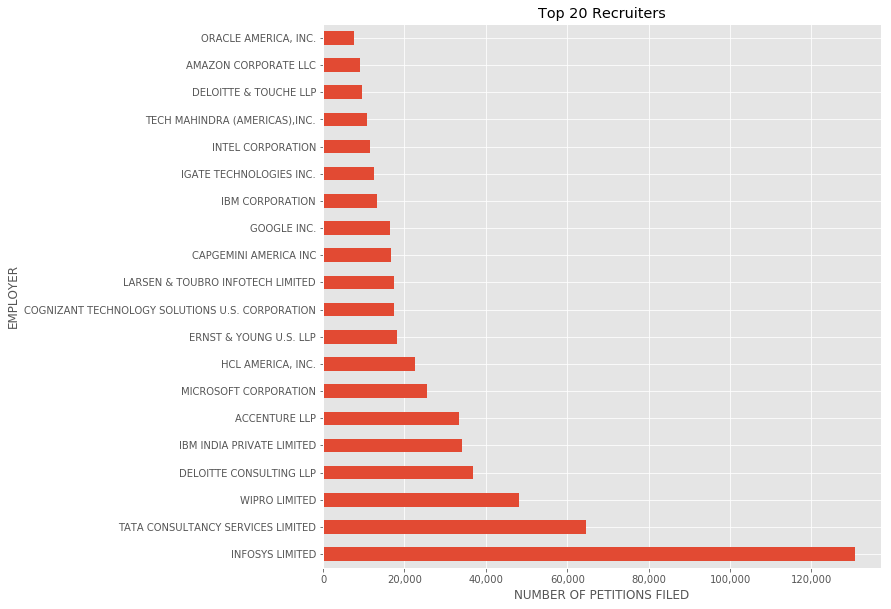

In [50]:
## top 20 employers by count of applications initiated for foreign employees
employer_ax = employer_group_df[("PREVAILING_WAGE", "count")].plot.barh(figsize=(10,10))
employer_ax.set(ylabel="EMPLOYER", xlabel="NUMBER OF PETITIONS FILED", title="Top 20 Recruiters")
# Format the X axis to present in a more readable format.
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
employer_ax.xaxis.set_major_formatter(tick) 

plt.show()

+ The top recruiters of international employees are Indian tech companies. 
+ We also have alot of American Tech companies sponsoring international as well as Consulting and Accounting Firms

#### FULL_TIME POSITIONS
---
#### What is the trend of full-time applications over the years

In [51]:
full_time_trend = df.groupby(["YEAR", "FULL_TIME_POSITION"]).size().unstack()
full_time_trend

FULL_TIME_POSITION,N,Y
YEAR,,
2011,16610,341780
2012,15639,399565
2013,13583,428125
2014,14201,504757
2015,15106,603512
2016,351133,296580


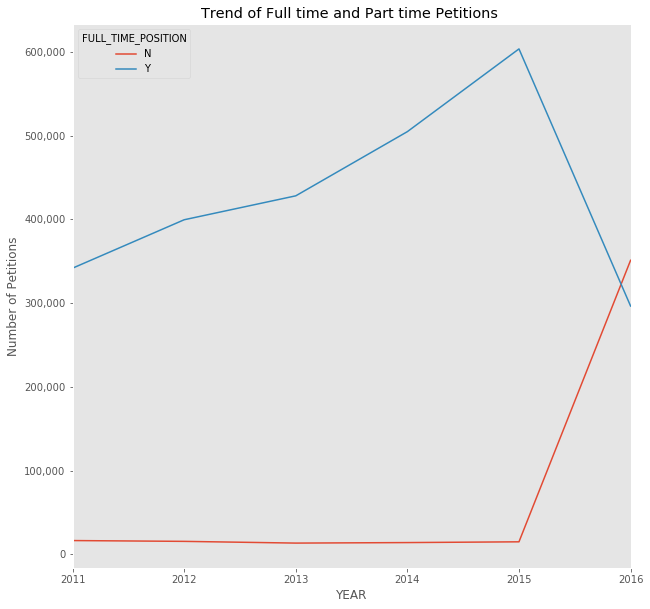

In [52]:
full_time_ax = full_time_trend.plot(kind="line", 
                                    figsize=(10,10), 
                                   grid=False)
full_time_ax.set(ylabel='Number of Petitions', 
                 xlabel='YEAR',
                 title= "Trend of Full time and Part time Petitions ")

# Format the y axis
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
full_time_ax.yaxis.set_major_formatter(tick) 

plt.show()

** Observation **
____
The number of part time pettions between 2011 - 2015 are constant but they increase in 2016, beyond the number of fulltime petition filed that year

#### YEAR
---
#### What is the trend with applications per year

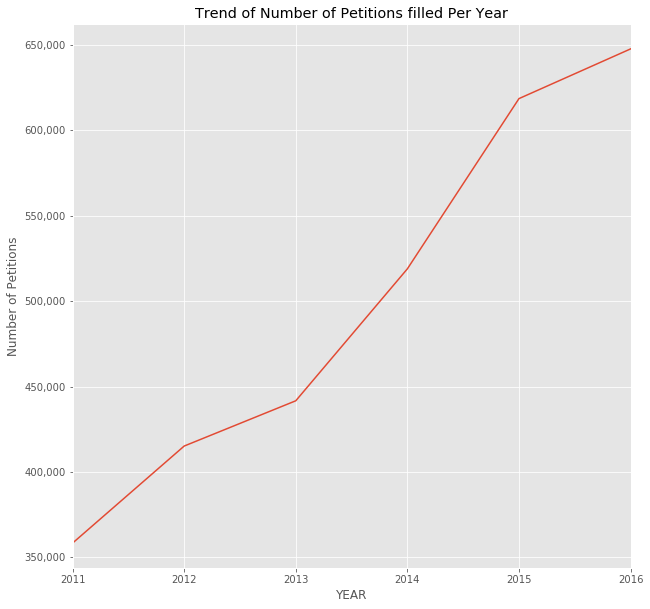

In [53]:
year_ax = df.groupby("YEAR").size().plot(kind="line", 
                                         figsize=(10,10))
year_ax.set(ylabel='Number of Petitions', 
            xlabel='YEAR',
            title="Trend of Number of Petitions filled Per Year")

# Format the y axis
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
year_ax.yaxis.set_major_formatter(tick) 

plt.show()

+ We see that the number of appplications filed each year between 2011 and 2016 keep increasing

#### Break-down of application status per year

In [54]:
applications_trend = df.groupby(["YEAR", "CASE_STATUS"]).size().unstack()
applications_trend

CASE_STATUS,CERTIFIED,CERTIFIED-WITHDRAWN,DENIED,WITHDRAWN
YEAR,,,,
2011,307911,11594,28818,10067
2012,352659,31118,20730,10697
2013,382943,35430,11780,11555
2014,455144,36350,11498,15966
2015,547274,41071,10839,19434
2016,569636,47092,9108,21877


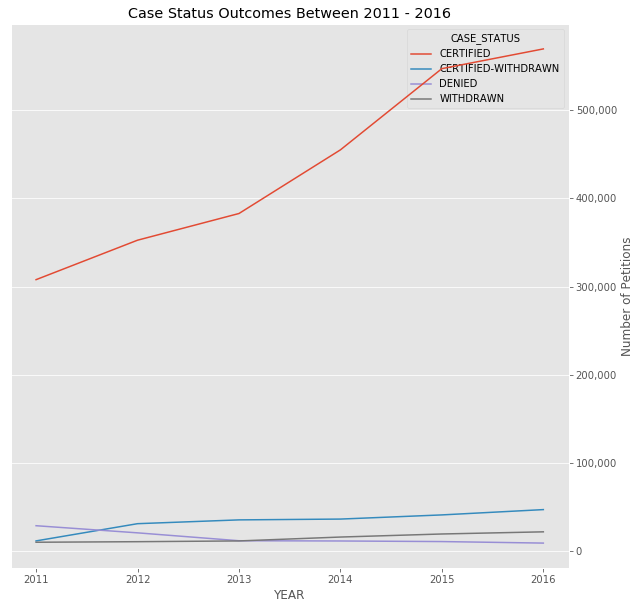

In [55]:
plt.figure()
app_ax = applications_trend.plot(secondary_y=['CERTIFIED', 'CERTIFIED-WITHDRAWN', 'DENIED', 'WITHDRAWN'],
                                 mark_right=False,
                                 figsize=(10,10))
app_ax.set(ylabel='Number of Petitions', 
            xlabel='YEAR',
            title="Case Status Outcomes Between 2011 - 2016")
# Format the y axis
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
app_ax.yaxis.set_major_formatter(tick) 
plt.autoscale()
plt.show()

---
+ **The number of application certified increases over time, probably because the number of application increase as well.**
+ **The number of applications denied are constant,**
+ **The number of applications certified-withdrawn have steadily increased and then leveled off**
+ **The number of applications denied reduced between 2011 and 2013 then leveled off**
---

In [56]:
# Average prevailing wages of applicants over the years. 
wages_trend_years = pd.pivot_table(df, 'PREVAILING_WAGE', ['YEAR'])
wages_trend_years

,PREVAILING_WAGE
YEAR,
2011,67040.402955
2012,68175.857114
2013,70021.560828
2014,71073.932318
2015,71791.538647
2016,73923.985700


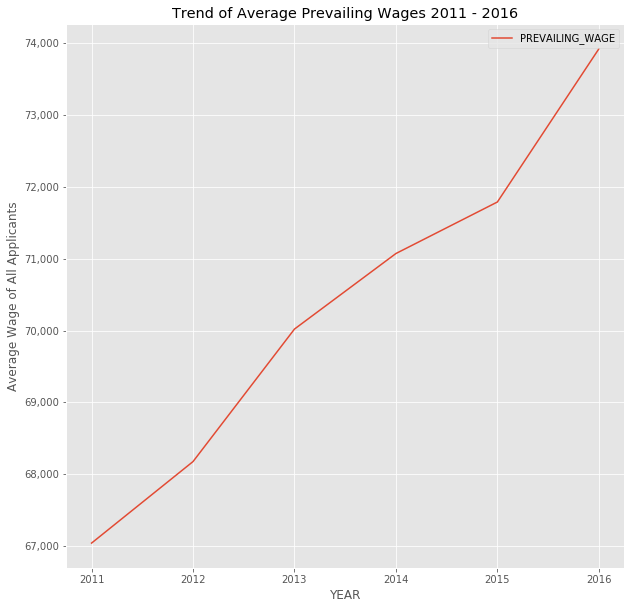

In [57]:
wage_ax = wages_trend_years.plot(kind="line", 
                                 figsize=(10,10))
wage_ax.set(ylabel='Average Wage of All Applicants', 
            xlabel='YEAR',
            title="Trend of Average Prevailing Wages 2011 - 2016")
# Format the y axis
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
wage_ax.yaxis.set_major_formatter(tick) 
plt.autoscale()
plt.show()

### City
---


#####  If you were a data Scientist or Data Analyst. What is the best city to work in such that you maximize your earnings ?

In [58]:
data_science1 = df["JOB_TITLE"] == 'DATA SCIENCE'
data_science2 = df["JOB_TITLE"] == 'DATA SCIENTIST'
analysts = df["JOB_TITLE"].str.contains("DATA ANALY")

In [59]:
data_analysts_df = df[data_science1 | data_science2 | analysts ]
count_analyst_jobs = len(data_analysts_df)
print("There {:.0f} petitions where the job title is Data Science or Data Analyst".format(count_analyst_jobs))

There 12106 petitions where the job title is Data Science or Data Analyst


In [60]:
analysts_city = data_analysts_df.groupby(["CITY"]).mean().sort_values("PREVAILING_WAGE", ascending=False)

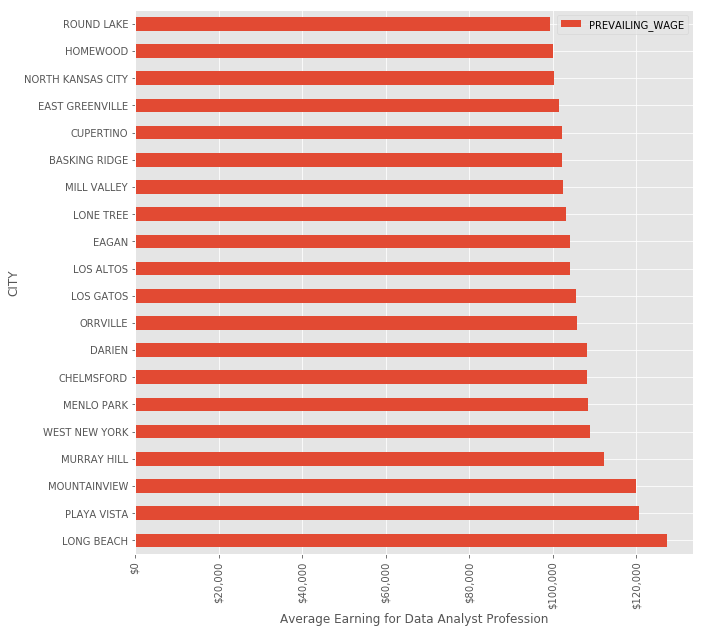

In [63]:
# Best Cities to be a Data Scientist or Data Analysts according to H1-B Wage Data 
analysts_sorted = analysts_city[:20]
analysts_sorted["PREVAILING_WAGE"].apply(lambda x: int(x))
analyst_ax = analysts_sorted[[("PREVAILING_WAGE")]].plot.barh(figsize=(10,10))
analyst_ax.set(ylabel='CITY', xlabel='Average Earning for Data Analyst Profession')
# Format the X axis to reflect dollars and present in a more readable format.
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
analyst_ax.xaxis.set_major_formatter(tick) 
plt.xticks(rotation=90)
plt.show()

** The best City to work in a Data Analyst or Data Scientist is Long Beach California **

### State
---

#####  If you were a data Scientist or Data Analyst. What is the best state to work in such that you maximize your earnings ?

In [66]:
top_20_cities = data_analysts_df

## Data Preprocessing
---
+ I have already removed the ouliers in the prevailing wage

In [67]:
df[df["YEAR"] > 2016]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE


In [68]:
df[df["YEAR"] < 2011]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE


In [69]:
print(df.dtypes)

CASE_STATUS           object
EMPLOYER_NAME         object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE        int64
YEAR                   int64
CITY                  object
STATE                 object
dtype: object


In [70]:
## Encoding labels to handle cateforical data 
to_be_encoded = df
for column in to_be_encoded.columns:
    if to_be_encoded[column].dtype == type(object):
        le = LabelEncoder()
        to_be_encoded[column] = le.fit_transform(to_be_encoded[column])

In [71]:
print(to_be_encoded.dtypes)

CASE_STATUS           int64
EMPLOYER_NAME         int64
JOB_TITLE             int64
FULL_TIME_POSITION    int64
PREVAILING_WAGE       int64
YEAR                  int64
CITY                  int64
STATE                 int64
dtype: object


In [72]:
# Remove the inf and nan values from the df -> Cause error when training
all_inf_or_nan = to_be_encoded.isin([np.inf, -np.inf, np.nan])
to_be_encoded = to_be_encoded[~all_inf_or_nan]

## Data Modeling
---
### Classification
---

In [84]:
# Check for null values
all_inf_or_nan = to_be_encoded.isin([np.inf, -np.inf, np.nan])
case_null = to_be_encoded[to_be_encoded["CASE_STATUS"].isnull()]
employee_null = to_be_encoded[to_be_encoded["EMPLOYER_NAME"].isnull()]
job_null = to_be_encoded[to_be_encoded["JOB_TITLE"].isnull()]
full_time_null = to_be_encoded[to_be_encoded["FULL_TIME_POSITION"].isnull()]
prevailing_wage_null = to_be_encoded[to_be_encoded["PREVAILING_WAGE"].isnull()]
year_null = to_be_encoded[to_be_encoded["YEAR"].isnull()]
state_null = to_be_encoded[to_be_encoded["STATE"].isnull()]
null_data_stats=[case_null, employee_null, job_null, full_time_null, prevailing_wage_null, year_null, state_null]
[len(i) for i in null_data_stats]
    

[0, 0, 0, 0, 0, 0, 0]

In [74]:
to_be_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
to_be_encoded.dropna(axis=1, inplace=True)

In [75]:
# First split the data 
X = to_be_encoded[["EMPLOYER_NAME", "JOB_TITLE", "FULL_TIME_POSITION", "PREVAILING_WAGE", "YEAR", "CITY", "STATE"] ]
y = to_be_encoded["CASE_STATUS"]


In [76]:
# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame)
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)

X[:2]

,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,219645,163507,0,36067,2016,824,22
1,86087,43256,1,242674,2016,8225,45


In [77]:
sss = StratifiedShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
sss

StratifiedShuffleSplit(n_splits=30, random_state=0, test_size=0.3,
            train_size=None)

In [78]:
# Split Data According to stratified sampling
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Use k-nearest neighbours classifier
___

In [79]:
y_train.count()

2099113

In [80]:
X_train.count()

EMPLOYER_NAME         2100413
JOB_TITLE             2100413
FULL_TIME_POSITION    2100413
PREVAILING_WAGE       2100413
YEAR                  2100413
CITY                  2100413
STATE                 2100413
dtype: int64

In [82]:
X[:10]

,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,219645,163507,0,36067,2016,824,22
1,86087,43256,1,242674,2016,8225,45
2,163458,43331,1,193066,2016,5172,31
3,81030,187217,1,220314,2016,2888,5
4,158392,164851,1,157518,2016,9885,25
5,33437,88169,1,225000,2016,6543,9
6,32925,43256,1,91021,2016,4927,45
7,84975,43299,1,150000,2016,9125,4
8,70166,164780,1,127546,2016,6403,45
9,121755,164780,1,154648,2016,10900,48


In [83]:
# Fit K-nearest neighbors model
neigh = KNeighborsClassifier(n_neighbors=3)
k_nearest_cls = neigh.fit(X_train, y_train) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').